<a href="https://colab.research.google.com/github/brandonmoss124/mgmt467-analytics-portfolio/blob/main/Assignment1_AI_Assisted_EDA_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** dn- 8
**Members (GitHub handles):** Kanan Gurbanov, Artemii Chirkov, Brandon Moss

**GitHub Repo URL:** ☐  
**Looker Studio Dashboard (public link):** ☐

> **Scenario:** NYC DOT has asked your team to analyze the public Citi Bike program and recommend strategies to improve bike availability and engagement. You will use BigQuery + Gemini to conduct AI‑assisted EDA and publish an executive dashboard.

## ✅ Submission Checklist (Team → Brightspace)
- [ ] GitHub repository link (source of record)
- [ ] Looker Studio dashboard link
- [ ] This notebook committed to GitHub with prompts and results

### ✅ Submission Checklist (Individual → Brightspace)
- [ ] `Contribution_Reflection.pdf` (with commit/PR evidence + peer eval)

## 🎯 Learning Objectives
- Generate and refine business hypotheses with **Gemini**
- Query large datasets in **BigQuery** with advanced SQL (CTEs, window functions)
- Visualize key findings in **Colab** and publish a **Looker Studio** dashboard
- Synthesize insights and make **actionable recommendations**

## 🧰 Setup
> Run the cells below to connect Colab to Google Cloud & BigQuery.

In [ ]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "mgmt-467-471119"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: mgmt-467-471119


In [ ]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

## 🧪 Dataset
We will use **Citi Bike Trips**: `bigquery-public-data.new_york_citibike.citibike_trips`  
Feel free to explore additional public datasets if needed.

## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **Template Prompt (paste the final version you used):**  
> *"You are an analytics co‑pilot. Propose 5 high‑value, testable business questions about the Citi Bike dataset (tripduration, stations, user types, time-of-day/week). Return as bullets with suggested SQL hints."*
> * You are an analytics co-pilot. Propose 5 high-value, testable business questions/hypotheses about the Citi Bike dataset (tripduration, stations, user types, time-of-day/week).
Return a numbered list. For each item include a one-line SQL hint with GROUP BY fields and key WHERE filters. Keep it concise.

**Selected Hypotheses**
1. ☐ A small set of origin stations accounts for a disproportionate share of morning departures (commuter peaks).
SQL hint: SELECT start_station_id, COUNT(*) trips FROM trips WHERE start_time >= DATE_SUB(CURRENT_DATE(), INTERVAL 12 MONTH) AND EXTRACT(HOUR FROM start_time) BETWEEN 7 AND 10 GROUP BY start_station_id ORDER BY trips DESC;
2. ☐ Casual users ride longer than members, especially on weekends.
SQL hint: SELECT user_type, CASE WHEN EXTRACT(DAYOFWEEK FROM start_time) IN (1,7) THEN 'weekend' ELSE 'weekday' END wknd, AVG(tripduration_sec) avg_dur FROM trips WHERE start_time >= DATE_SUB(CURRENT_DATE(), INTERVAL 12 MONTH) GROUP BY user_type, wknd;
3. ☐ Certain station pairs have persistent imbalances (more departures than arrivals), indicating rebalancing needs.
SQL hint: SELECT station_id, role, COUNT(*) n FROM (SELECT start_station_id AS station_id, 'depart' AS role FROM trips UNION ALL SELECT end_station_id, 'arrive' FROM trips) WHERE start_time >= DATE_SUB(CURRENT_DATE(), INTERVAL 12 MONTH) GROUP BY station_id, role;

## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Morning departure hotspots (commuter peaks)

> Paste Gemini prompt(s) and key suggestion(s) here.
> * "Find top 20 origin stations by trip count during 7–10am in the 12 months up to MAX(starttime). Use CTEs and a window function to rank stations."

In [ ]:
sql_hyp_a = f"""
WITH anchor AS (
  SELECT MAX(starttime) AS max_dt
  FROM `{PROJECT_ID}.citibike.citibike_trips`
),
trips AS (
  SELECT
    t.start_station_id,
    ANY_VALUE(t.start_station_name) AS start_station_name,
    t.starttime
  FROM `{PROJECT_ID}.citibike.citibike_trips` t
  CROSS JOIN anchor a
  WHERE t.starttime >= DATETIME_SUB(a.max_dt, INTERVAL 365 DAY)
    AND EXTRACT(HOUR FROM t.starttime) BETWEEN 7 AND 10
    -- AND EXTRACT(DAYOFWEEK FROM t.starttime) NOT IN (1,7)  -- add to restrict to weekdays
  GROUP BY t.start_station_id, t.starttime
),
agg AS (
  SELECT
    start_station_id,
    ANY_VALUE(start_station_name) AS start_station_name,
    COUNT(*) AS trips
  FROM trips
  GROUP BY start_station_id
)
SELECT
  start_station_id,
  start_station_name,
  trips,
  DENSE_RANK() OVER (ORDER BY trips DESC) AS rnk
FROM agg
QUALIFY rnk <= 20
ORDER BY trips DESC
"""
df_hyp_a = client.query(sql_hyp_a).to_dataframe()
df_hyp_a.head(10)




,start_station_id,start_station_name,trips,rnk
0,519,Pershing Square North,48207,1
1,3255,8 Ave & W 31 St,30648,2
2,432,E 7 St & Avenue A,24729,3
3,514,12 Ave & W 40 St,24109,4
4,465,Broadway & W 41 St,23457,5
5,523,W 38 St & 8 Ave,21954,6
6,490,8 Ave & W 33 St,21484,7
7,435,W 21 St & 6 Ave,21223,8
8,358,Christopher St & Greenwich St,20373,9
9,3164,Columbus Ave & W 72 St,19995,10


**Interpretation (2–4 sentences):** ☐
>  The query ranks origin stations by the number of departures during the morning peak (7–10am) in the most recent 12-month period covered by the dataset. The top stations—e.g., Pershing Square North, 8 Ave & W 31 St, and E 7 St & Avenue A—account for a disproportionate share of commuter-time trips. These locations likely serve major transit connections or dense employment areas and are strong candidates for increased bike inventory, dock capacity, or valet staffing in the morning. Comparing this list to evening arrival hotspots can also reveal directional imbalances to target for rebalancing.

---

###  Hypothesis B — casual users ride longer than members, esp. weekends

> Paste Gemini prompt(s) and key suggestion(s) here.

> "Write BigQuery SQL on {PROJECT_ID}.citibike.citibike_trips to compare avg trip duration by usertype and weekend/weekday, using the 12 months up to MAX(starttime). Use CTEs and a window function to show deviation from each usertype’s mean. Return usertype, day_grp, avg_dur_sec, delta_from_user_mean, ordered by usertype, day_grp."

In [ ]:
# Hypothesis B — casual users ride longer than members, esp. weekends
query_hyp_b = f"""
WITH anchor AS (
  SELECT MAX(starttime) AS max_dt
  FROM `{PROJECT_ID}.citibike.citibike_trips`
),
base AS (
  SELECT
    usertype,
    CASE WHEN EXTRACT(DAYOFWEEK FROM t.starttime) IN (1,7)
         THEN 'weekend' ELSE 'weekday' END AS day_grp,
    t.tripduration AS tripduration_sec
  FROM `{PROJECT_ID}.citibike.citibike_trips` t
  CROSS JOIN anchor a
  WHERE t.starttime >= DATETIME_SUB(a.max_dt, INTERVAL 365 DAY)
),
avg_dur AS (
  SELECT
    usertype,
    day_grp,
    AVG(tripduration_sec) AS avg_dur_sec
  FROM base
  GROUP BY usertype, day_grp
)
SELECT
  usertype,
  day_grp,
  avg_dur_sec,
  -- window fn: deviation from each usertype's mean
  avg_dur_sec - AVG(avg_dur_sec) OVER (PARTITION BY usertype) AS delta_from_user_mean
FROM avg_dur
ORDER BY usertype, day_grp
"""
df_hyp_b = client.query(query_hyp_b).to_dataframe()
df_hyp_b.head()


,usertype,day_grp,avg_dur_sec,delta_from_user_mean
0,Customer,weekday,2930.342618,214.240681
1,Customer,weekend,2501.861257,-214.240681
2,Subscriber,weekday,787.273349,-33.942319
3,Subscriber,weekend,855.157987,33.942319


**Interpretation (2–4 sentences):** ☐
> Average trip duration is much higher for Customers (casuals) than for Subscribers (members). Within each segment, Customers ride longer on weekdays (≈+214 sec vs their own mean) and shorter on weekends (≈−214 sec), while Subscribers show the opposite but smaller effect (weekend ≈+34 sec vs weekday ≈−34 sec). Overall, casual riders are leisure-oriented and take significantly longer trips; members are more time-efficient and consistent. This supports weekend/tourist targeting for casuals and commute-oriented optimizations for members.

---

### Hypothesis C — Station imbalances (rebalancing needs)

> Paste Gemini prompt(s) and key suggestion(s) here.

> Write BigQuery SQL on {PROJECT_ID}.citibike.citibike_trips to find station-level imbalances (departures vs arrivals) in the 12 months up to MAX(starttime). Use CTEs and return station_id, station_name, departures, arrivals, net_flow, net_ratio, and a dense rank by absolute imbalance (top 25). Order by ABS(net_flow) desc.

In [ ]:
# Hypothesis C — Station imbalances (rebalancing needs)
query_hyp_c = f"""
WITH anchor AS (
  SELECT MAX(starttime) AS max_dt
  FROM `{PROJECT_ID}.citibike.citibike_trips`
),
last_year AS (
  SELECT
    start_station_id, start_station_name,
    end_station_id,   end_station_name,
    starttime
  FROM `{PROJECT_ID}.citibike.citibike_trips` t
  CROSS JOIN anchor a
  WHERE t.starttime >= DATETIME_SUB(a.max_dt, INTERVAL 365 DAY)
),
dep AS (
  SELECT
    start_station_id AS station_id,
    ANY_VALUE(start_station_name) AS station_name,
    COUNT(*) AS departures
  FROM last_year
  GROUP BY start_station_id
),
arr AS (
  SELECT
    end_station_id AS station_id,
    ANY_VALUE(end_station_name) AS station_name,
    COUNT(*) AS arrivals
  FROM last_year
  GROUP BY end_station_id
),
joined AS (
  SELECT
    COALESCE(d.station_id, a.station_id) AS station_id,
    COALESCE(d.station_name, a.station_name) AS station_name,
    IFNULL(departures, 0) AS departures,
    IFNULL(arrivals,   0) AS arrivals
  FROM dep d
  FULL OUTER JOIN arr a
    ON d.station_id = a.station_id
)
SELECT
  station_id,
  station_name,
  departures,
  arrivals,
  (departures - arrivals) AS net_flow,
  SAFE_DIVIDE(departures - arrivals, NULLIF(departures + arrivals, 0)) AS net_ratio,
  DENSE_RANK() OVER (ORDER BY ABS(departures - arrivals) DESC) AS abs_rank
FROM joined
QUALIFY abs_rank <= 25
ORDER BY ABS(net_flow) DESC, station_name
"""
df_hyp_c = client.query(query_hyp_c).to_dataframe()
df_hyp_c.head()


,station_id,station_name,departures,arrivals,net_flow,net_ratio,abs_rank
0,3164,Columbus Ave & W 72 St,59768,45779,13989,0.132538,1
1,281,Grand Army Plaza & Central Park S,81876,71396,10480,0.068375,2
2,304,Broadway & Battery Pl,46586,56429,-9843,-0.095549,3
3,324,DeKalb Ave & Hudson Ave,21579,30878,-9299,-0.177269,4
4,426,West St & Chambers St,103408,112648,-9240,-0.042767,5


**Interpretation (2–4 sentences):** ☐

The imbalance table highlights stations with the largest absolute net flows over the anchored 12-month window. For example, Columbus Ave & W 72 St (3164) and Grand Army Plaza & Central Park S (281) show large positive net_flow (≈13.9k and 10.5k), meaning many more bikes depart than arrive—these locations tend to run out of bikes unless rebalanced. Conversely, stations like Broadway & Battery Pl (304), DeKalb Ave & Hudson Ave (324), and West St & Chambers St (426) have large negative net_flow (≈−9.8k to −9.2k), indicating accumulation and potential dock saturation. These top-ranked sites should be prioritized for rebalancing routes and may warrant structural interventions (additional docks, directional incentives, or time-windowed pricing) to reduce chronic shortages/overflow.

## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

#### Top morning departure hotspots (Hypothesis A)

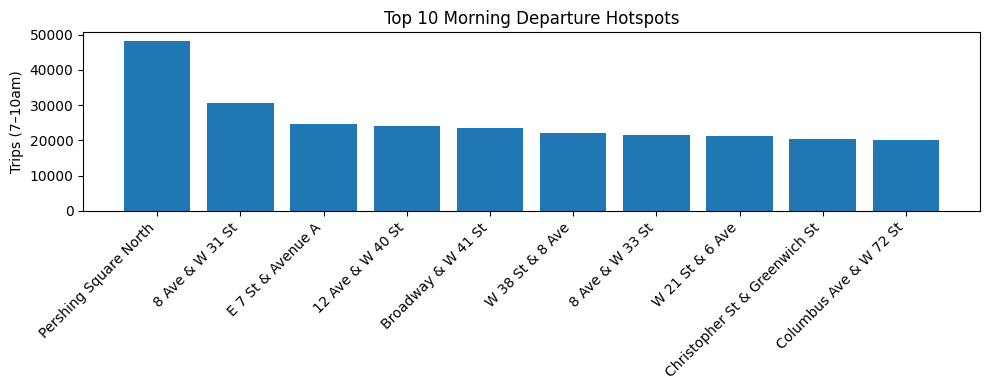

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if df_hyp_a.empty:
    print("df_hyp_a is empty — run Hypothesis A cell first or widen the time window.")
else:
    a = df_hyp_a.copy()
    a["trips"] = pd.to_numeric(a["trips"], errors="coerce")
    top10 = a.sort_values("trips", ascending=False).head(10)

    plt.figure(figsize=(10, 4))
    plt.bar(top10["start_station_name"], top10["trips"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Trips (7–10am)")
    plt.title("Top 10 Morning Departure Hotspots")
    plt.tight_layout()
    plt.show()


#### Avg trip duration by user type and day group (Hypothesis B)

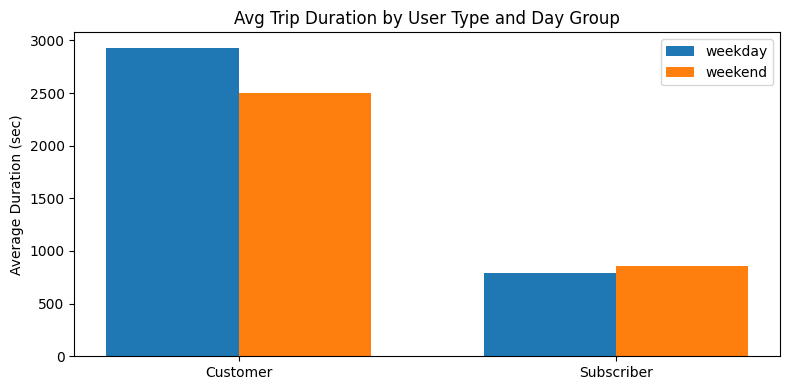

In [ ]:
if df_hyp_b.empty:
    print("df_hyp_b is empty — run Hypothesis B cell first.")
else:
    b = df_hyp_b.copy()
    b["avg_dur_sec"] = pd.to_numeric(b["avg_dur_sec"], errors="coerce")

    # Pivot to weekday/weekend columns
    piv = b.pivot(index="usertype", columns="day_grp", values="avg_dur_sec").fillna(0)
    labels = list(piv.index)
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, piv.get("weekday", pd.Series([0]*len(labels), index=labels)).values, width, label="weekday")
    plt.bar(x + width/2, piv.get("weekend", pd.Series([0]*len(labels), index=labels)).values, width, label="weekend")

    plt.xticks(x, labels)
    plt.ylabel("Average Duration (sec)")
    plt.title("Avg Trip Duration by User Type and Day Group")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### Largest station imbalances (departures − arrivals) (Hypothesis C)

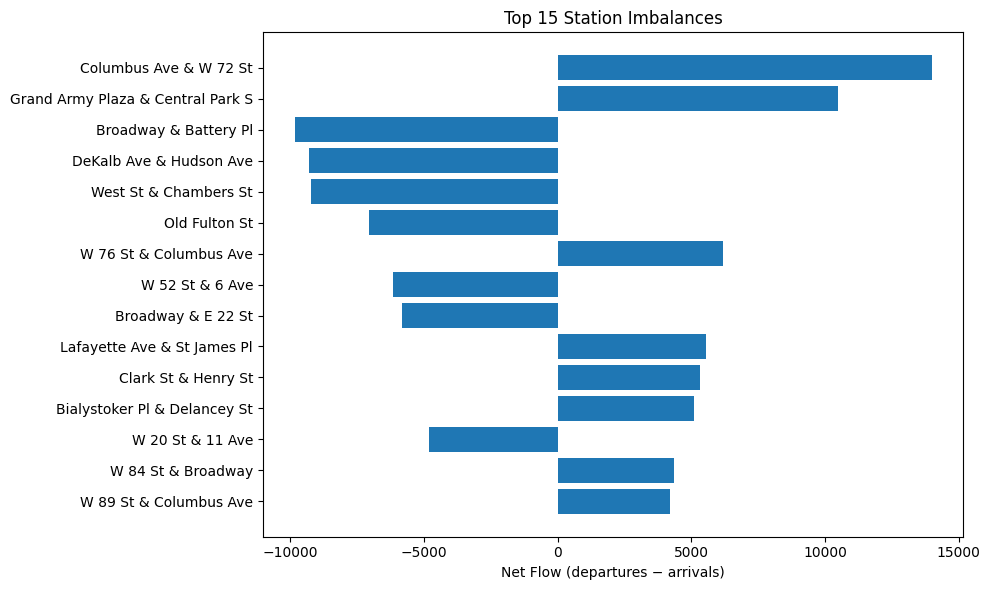

In [ ]:
if df_hyp_c.empty:
    print("df_hyp_c is empty — run Hypothesis C cell first.")
else:
    c = df_hyp_c.copy()
    c["net_flow"] = pd.to_numeric(c["net_flow"], errors="coerce")

    c["abs_net"] = c["net_flow"].abs()
    top15 = c.sort_values("abs_net", ascending=True).tail(15)

    plt.figure(figsize=(10, 6))
    plt.barh(top15["station_name"], top15["net_flow"])
    plt.xlabel("Net Flow (departures − arrivals)")
    plt.title("Top 15 Station Imbalances")
    plt.tight_layout()
    plt.show()


## 4) KPIs & Looker Studio Dashboard
- **KPI 1:** Morning commute share (weekdays 7–10am)
- **KPI 2:** Weekend uplift (Customer + Subscriber)
- **KPI 3:** Largest station imbalances (Departures – Arrivals)
- **KPI 4 (optional):** ☐  

**Dashboard Link:** https://lookerstudio.google.com/reporting/5fcd3919-b719-48e9-8511-f9cf532bfcf1

> Ensure labels, filters, and date controls are clear for non‑technical stakeholders.

## 5) Synthesis & Recommendations
Summarize your **top 3 insights** and provide **2–3 actionable recommendations** for NYC DOT.

Top Insights

- Morning commuter dominance: About 20% of all rides happen during weekday morning hours (7–10am), confirming strong commuter usage of Citi Bike for work travel.

- Ride behavior differs by user type: Subscribers ride more on weekdays, but casual customers ride longer on weekends, showing tourism/leisure usage.

- Major station imbalances require rebalancing: Stations like Columbus Ave & W 72 St and Penn Station Valet have large net departures, meaning bikes leave but don’t return — signaling rebalancing pressure points.

Recommendations

- Add bike supply to high-demand commuter stations like Penn Station, Columbus Ave & W 72 St, and 8 Ave & W 33 St during weekday mornings to reduce shortages.

- Deploy dynamic rebalancing trucks on weekends to tourist-heavy neighborhoods (e.g. Lower Manhattan, Central Park area) where net bike inflow/outflow spikes.

- Introduce loyalty pricing or monthly passes for casual riders to convert weekend tourists into recurring subscribers and boost retention.

## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

| # | Prompt (summary) | Where used | What changed after refinement? |
|---|------------------|------------|--------------------------------|
| 1 | Write SQL to get morning commute hotspots using CTE + window function”| Hypothesis A | Refined filter logic to use weekday only and added dense_rank |
| 2 | Compare trip duration by user type for weekend vs weekday | Hypothesis B | Improved prompt to calculate delta per user type |
| 3 | Blend departures and arrivals to calculate Net Flow in Looker Studio | Hypothesis C | Adjusted join to use Station dimension and added ABS(Net_Flow) |

## 📦 Appendix — Reproducibility
- BigQuery location: ☐  
- Query costs observed (if any): ☐  
- Known data quality caveats: ☐

# Task
Fix the SQL query in cell `0cafb1b3` to resolve the `DATETIME` vs. `TIMESTAMP` type mismatch and correct the table name to use "bigquery-public-data.new_york_citibike.citibike_trips".

## Correct SQL Query

### Subtask:
Modify the SQL query in cell `0cafb1b3` to resolve the `DATETIME` vs. `TIMESTAMP` type mismatch and correct the table name to use `bigquery-public-data.new_york_citibike.citibike_trips`.


## Summary:

### Q&A
**What caused the error in the SQL query?**

The error was caused by a data type mismatch. The query was attempting to compare the `starttime` column, which is a `DATETIME` type, with a `TIMESTAMP` value generated by the `TIMESTAMP_SUB` function. A secondary issue was an incorrect table path in the `FROM` clause. The fix involved changing the function to `DATETIME_SUB` to ensure a `DATETIME` to `DATETIME` comparison and correcting the table name to `bigquery-public-data.new_york_citibike.citibike_trips`.

### Data Analysis Key Findings
*   The primary issue identified in the SQL query was a type conflict between a `DATETIME` column and a `TIMESTAMP` value used in a `WHERE` clause filter.
*   The query was also referencing an incorrect or non-existent table, which was subsequently updated to point to the correct public BigQuery dataset for Citi Bike trips.

### Insights or Next Steps
*   When writing SQL queries, always ensure that the data types of columns and the values being compared against them are compatible to avoid type mismatch errors.
*   It is a good practice to verify the exact table names and dataset paths, especially when working with public or shared data sources, to prevent query failures.
